In [607]:
import glob
# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 

genSavePath = "F:/PythonProjects/NietoExcercise-1/SavedResults/"
day = "16" # Which month and days result you want to visualize in table
month = 11

repetitionValue = 25
repetitionName =  "thisWorksma"#  "udrli1feattestanglnoBC"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBest*")

saveTop = False
if saveTop:
    saveTopName = "top3udrli.npy"
else:
    saveTopName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.1
print(len(savedResults))
print(len(savedResults)/9)

90
10.0


In [608]:
import pandas as pd
from array import ArrayType
from requests import delete
import numpy as np


nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0

currSeed = 0
currSubj = 0
combinationList = []

testInfoPerSubject = [None] * 10

results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
    
for subject in results:
    currSubj = subject[1]
    testInfoPerSubject[currSubj] = subject[0]
soloFeatures = []
featCombos = []
kernels = testInfoPerSubject[1][2][0]
regValues = testInfoPerSubject[1][2][1]
paradigmName = testInfoPerSubject[1][3]
for subinfo in testInfoPerSubject[1:]:
    if subinfo is None:
        continue
    subSoloFeatures = subinfo[0]
    subfeatCombos = subinfo[1]
    if len(soloFeatures) < len(subSoloFeatures):
        soloFeatures = subSoloFeatures
    if len(featCombos) < len(subfeatCombos):
        featCombos = subfeatCombos
    #print(subinfo)
allCombinations = []
comboNumber = 0
combinationDict = dict()
for featCombo in featCombos:
    for kernel in kernels:
        for regValue in regValues:
            allCombinations.append([featCombo, kernel, regValue, comboNumber])
            combinationDict[f"{featCombo},{kernel},{regValue}"] = comboNumber
            comboNumber = comboNumber + 1
#print(combinationDict)
nrOfCombination = len(allCombinations)
combinationResult = np.zeros([subjectAmount, len(allCombinations), 2])
nrOfSeedsPerSubject = np.zeros(subjectAmount)
seedCounted = np.zeros([subjectAmount, len(allCombinations), (len(savedResults)//9)+1])
currSeed = -1
for s, subject in enumerate(results):
    currSubj = 0
    
    subjectBestArray = np.empty([len(subject)], dtype=object)

    
    currSubj = subject[1]
    if currSubj == 1:
        currSeed = currSeed + 1 
    testInfoPerSubject[currSubj] = subject[0]
    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 6:

                aName = aResults2[0]
                ares = aResults2[1]

                # if type(ares) is tuple:
                #     ares = ares[0]
                # if ares > 0.98:
                #     ares = 0.99
                akernel = aResults2[2]
            
                aC = aResults2[3]
                if seedCounted[currSubj, combinationDict[f"{aName},{akernel},{aC}"], currSeed] == 1:
                    continue
                seedCounted[currSubj, combinationDict[f"{aName},{akernel},{aC}"], currSeed] = 1
                combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]] = [int(combinationDict[f"{aName},{akernel},{aC}"]), 
                                                                                           combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][1] + ares]
               

for subNr, subj in enumerate(combinationResult[1:], 1):
    combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / nrOfSeedsPerSubject[subNr]
    if "adaBoost" in kernels:
        combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / 2

headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
topPerFeature = np.zeros([10, len(featCombos)])

lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
    
            cmbNr = int(res[0])

            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
            comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
            nrOfSubjects[cmbNr] += 1
            subjectResultArray[subNr, cmbNr] = res[1]
            comboName = allCombinations[cmbNr][0]

            nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
            
   
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort()
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()
                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort()
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
        
        
        
# Print the table!
comboAverage = comboAverage / nrOfSubjects
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
for hcol, in zip(headers):
    if all(subjectResultArray[:,hcol] == None):
        atleastOneEmpty = True
        emptyCols.append(hcol)
if atleastOneEmpty: 
    subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    headers = np.delete(headers, np.array(emptyCols),0)
    comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)




C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_16756\1082744460.py:162: RuntimeWarning: invalid value encountered in divide
  comboAverage = comboAverage / nrOfSubjects


0         6         7         8         9         10        11    \
0      None      None      None      None      None      None      None   
1      0.71    0.6725    0.6925    0.6975    0.6975     0.695     0.695   
2    0.7375  0.652083  0.689583      0.75  0.791667   0.76875   0.76875   
3  0.694444  0.702778  0.705556  0.705556  0.708333  0.702778  0.702778   
4  0.691667  0.672917  0.691667  0.739583    0.7125  0.697917  0.697917   
5    0.7375   0.64375  0.689583   0.71875  0.733333  0.741667   0.74375   
6  0.686364  0.715909  0.729545  0.727273  0.697727  0.688636  0.686364   
7  0.704167  0.685417  0.677083    0.6875  0.691667    0.6875    0.6875   
8    0.7225    0.7075    0.7075    0.7075    0.7125    0.6975    0.7175   
9  0.683333   0.69375       0.7   0.73125   0.71875  0.714583  0.714583   

       12        13        14        15        16        17        18    \
0      None      None      None      None      None      None      None   
1    0.6225       0.7       0.7    0.7025    0.7025     0.705     0.595   
2  0.647917  0.672917  0.708333  0.733333  0.760417     0.725  0.545833   
3  0.711111  0.705556  0.705556  0.702778  0.705556  0.688889  0.491667   
4  0.652083  0.695833  0.739583  0.716667   0.69375  0.702083    0.6625   
5   0.64375   0.71875  0.720833   0.73125  0.747917  0.704167   0.63125   
6  0.681818  0.740909  0.729545  0.718182  0.695455  0.695455  0.497727   
7    0.6875  0.672917  0.683333  0.704167  0.702083       0.7  0.602083   
8    0.7075    0.7075    0.7075    0.7075    0.7125      0.71    0.6875   
9   0.68125  0.695833  0.704167  0.702083  0.689583   0.68125   0.34375   

       24        25        26        27        28        29        30    \
0      None      None      None      None      None      None      None   
1    0.5125    0.5125     0.595    0.6225    0.6225    0.6225     0.605   
2  0.416667  0.452083  0.558333  0.558333   0.55625  0.554167  0.472917   
3  0.383333  0.383333  0.458333  0.497222  0.488889  0.488889  0.394444   
4  0.616667   0.64375  0.679167  0.660417  0.660417  0.660417      0.65   
5  0.489583  0.489583    0.5875  0.627083     0.625     0.625  0.566667   
6  0.363636  0.361364  0.488636  0.497727  0.493182  0.493182  0.315909   
7  0.604167  0.614583   0.63125   0.60625  0.602083  0.602083  0.685417   
8    0.6225    0.6275    0.6775    0.6775    0.6525    0.6475    0.7275   
9  0.270833   0.26875  0.308333  0.352083   0.35625   0.35625  0.329167   

       31        32        33        34        35        54        60    \
0      None      None      None      None      None      None      None   
1    0.6125    0.6175    0.5725    0.5825    0.5675    0.6875      0.66   
2   0.54375   0.56875  0.547917  0.504167   0.46875  0.689583  0.616667   
3  0.402778  0.486111  0.469444  0.416667  0.380556  0.630556  0.572222   
4  0.679167  0.683333  0.647917    0.6375  0.629167  0.660417  0.658333   
5   0.60625   0.60625    0.5875  0.552083  0.504167   0.64375  0.577083   
6  0.334091  0.422727  0.454545  0.438636  0.372727  0.759091  0.627273   
7   0.65625  0.645833  0.616667  0.564583  0.533333  0.620833  0.595833   
8      0.72    0.7425    0.7575     0.695     0.655    0.6525      0.69   
9   0.33125  0.358333   0.36875  0.345833   0.33125  0.627083  0.470833   

       61        62        63        64        65        66        67    \
0      None      None      None      None      None      None      None   
1    0.6825    0.6925     0.705    0.6975    0.6975    0.7075    0.7075   
2     0.625  0.666667  0.635417      0.65      0.65     0.675     0.675   
3     0.575  0.638889  0.608333  0.597222  0.597222  0.702778  0.705556   
4   0.66875  0.704167  0.670833  0.670833  0.670833    0.6625  0.654167   
5       0.6  0.633333  0.641667  0.608333       0.6  0.672917  0.666667   
6  0.659091  0.681818  0.681818  0.684091  0.684091  0.743182  0.740909   
7   0.63125  0.627083  0.616667   0.60625  0.602083  0.652083  0.658333   
8     0.695    0.6975    0.6

In [609]:
pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
table = pd.DataFrame(topPerFeature, columns=featCombos)
display(table)


,fftData_&_welchData_CV_&_fftData_BC,fftData_&_gausData_CV_&_gausData_BC_CV,fftData_&_fftData_BC_&_stftData_CV,fftData_&_hilbertData_BC_CV_&_gausData_CV_BC,fftData_&_welchData_BC_&_stftData_CV,fftData_&_fftData_BC_&_stftData_CV,fftData_&_fftData_BC_&_gausData_BC,fftData_&_fftData_BC_&_welchData_BC,fftData_&_fftData_BC_&_gausData_BC_CV,welchData_&_welchData_CV_&_fftData_BC,welchData_&_gausData_CV_&_gausData_BC_CV,welchData_&_fftData_BC_&_stftData_CV,welchData_&_hilbertData_BC_CV_&_gausData_CV_BC,welchData_&_welchData_BC_&_stftData_CV,welchData_&_fftData_BC_&_stftData_CV,welchData_&_fftData_BC_&_gausData_BC,welchData_&_fftData_BC_&_welchData_BC,welchData_&_fftData_BC_&_gausData_BC_CV,hilbertData_&_welchData_CV_&_fftData_BC,hilbertData_&_gausData_CV_&_gausData_BC_CV,hilbertData_&_fftData_BC_&_stftData_CV,hilbertData_&_hilbertData_BC_CV_&_gausData_CV_BC,hilbertData_&_welchData_BC_&_stftData_CV,hilbertData_&_fftData_BC_&_stftData_CV,hilbertData_&_fftData_BC_&_gausData_BC,hilbertData_&_fftData_BC_&_welchData_BC,hilbertData_&_fftData_BC_&_gausData_BC_CV,fftData_CV_&_welchData_CV_&_fftData_BC,fftData_CV_&_gausData_CV_&_gausData_BC_CV,fftData_CV_&_fftData_BC_&_stftData_CV,fftData_CV_&_hilbertData_BC_CV_&_gausData_CV_BC,fftData_CV_&_welchData_BC_&_stftData_CV,fftData_CV_&_fftData_BC_&_stftData_CV,fftData_CV_&_fftData_BC_&_gausData_BC,fftData_CV_&_fftData_BC_&_welchData_BC,fftData_CV_&_fftData_BC_&_gausData_BC_CV,welchData_CV_&_gausData_CV_&_gausData_BC_CV,welchData_CV_&_fftData_BC_&_stftData_CV,welchData_CV_&_hilbertData_BC_CV_&_gausData_CV_BC,welchData_CV_&_welchData_BC_&_stftData_CV,welchData_CV_&_fftData_BC_&_stftData_CV,welchData_CV_&_fftData_BC_&_gausData_BC,welchData_CV_&_fftData_BC_&_welchData_BC,welchData_CV_&_fftData_BC_&_gausData_BC_CV,hilbertData_CV_&_welchData_CV_&_fftData_BC,hilbertData_CV_&_gausData_CV_&_gausData_BC_CV,hilbertData_CV_&_fftData_BC_&_stftData_CV,hilbertData_CV_&_hilbertData_BC_CV_&_gausData_CV_BC,hilbertData_CV_&_welchData_BC_&_stftData_CV,hilbertData_CV_&_fftData_BC_&_stftData_CV,hilbertData_CV_&_fftData_BC_&_gausData_BC,hilbertData_CV_&_fftData_BC_&_welchData_BC,hilbertData_CV_&_fftData_BC_&_gausData_BC_CV,gausData_&_welchData_CV_&_fftData_BC,gausData_&_gausData_CV_&_gausData_BC_CV,gausData_&_fftData_BC_&_stftData_CV,gausData_&_hilbertData_BC_CV_&_gausData_CV_BC,gausData_&_welchData_BC_&_stftData_CV,gausData_&_fftData_BC_&_stftData_CV,gausData_&_fftData_BC_&_gausData_BC,gausData_&_fftData_BC_&_welchData_BC,gausData_&_fftData_BC_&_gausData_BC_CV,fftData_BC_&_gausData_CV_&_gausData_BC_CV,fftData_BC_&_hilbertData_BC_CV_&_gausData_CV_BC,fftData_BC_&_welchData_BC_&_stftData_CV,welchData_BC_&_welchData_CV_&_fftData_BC,welchData_BC_&_gausData_CV_&_gausData_BC_CV,welchData_BC_&_fftData_BC_&_stftData_CV,welchData_BC_&_hilbertData_BC_CV_&_gausData_CV_BC,welchData_BC_&_fftData_BC_&_stftData_CV,welchData_BC_&_fftData_BC_&_gausData_BC,welchData_BC_&_fftData_BC_&_gausData_BC_CV,hilbertData_BC_&_welchData_CV_&_fftData_BC,hilbertData_BC_&_gausData_CV_&_gausData_BC_CV,hilbertData_BC_&_fftData_BC_&_stftData_CV,hilbertData_BC_&_hilbertData_BC_CV_&_gausData_CV_BC,hilbertData_BC_&_welchData_BC_&_stftData_CV,hilbertData_BC_&_fftData_BC_&_stftData_CV,hilbertData_BC_&_fftData_BC_&_gausData_BC,hilbertData_BC_&_fftData_BC_&_welchData_BC,hilbertData_BC_&_fftData_BC_&_gausData_BC_CV,fftData_BC_CV_&_welchData_CV_&_fftData_BC,fftData_BC_CV_&_gausData_CV_&_gausData_BC_CV,fftData_BC_CV_&_fftData_BC_&_stftData_CV,fftData_BC_CV_&_hilbertData_BC_CV_&_gausData_CV_BC,fftData_BC_CV_&_welchData_BC_&_stftData_CV,fftData_BC_CV_&_fftData_BC_&_stftData_CV,fftData_BC_CV_&_fftData_BC_&_gausData_BC,fftData_BC_CV_&_fftData_BC_&_welchData_BC,fftData_BC_CV_&_fftData_BC_&_gausData_BC_CV,welchData_BC_CV_&_welchData_CV_&_fftData_BC,welchData_BC_CV_&_gausData_CV_&_gausData_BC_CV,welchData_BC_CV_&_fftData_BC_&_stftData_CV,welchData_BC_CV_&_hilbertData_BC_CV_&_gausData_CV_BC,welchData_BC_CV_&_welchData_BC_&_stftData_CV,welchData_BC_CV_&_fftData_BC_&_stftData_C

(207,)




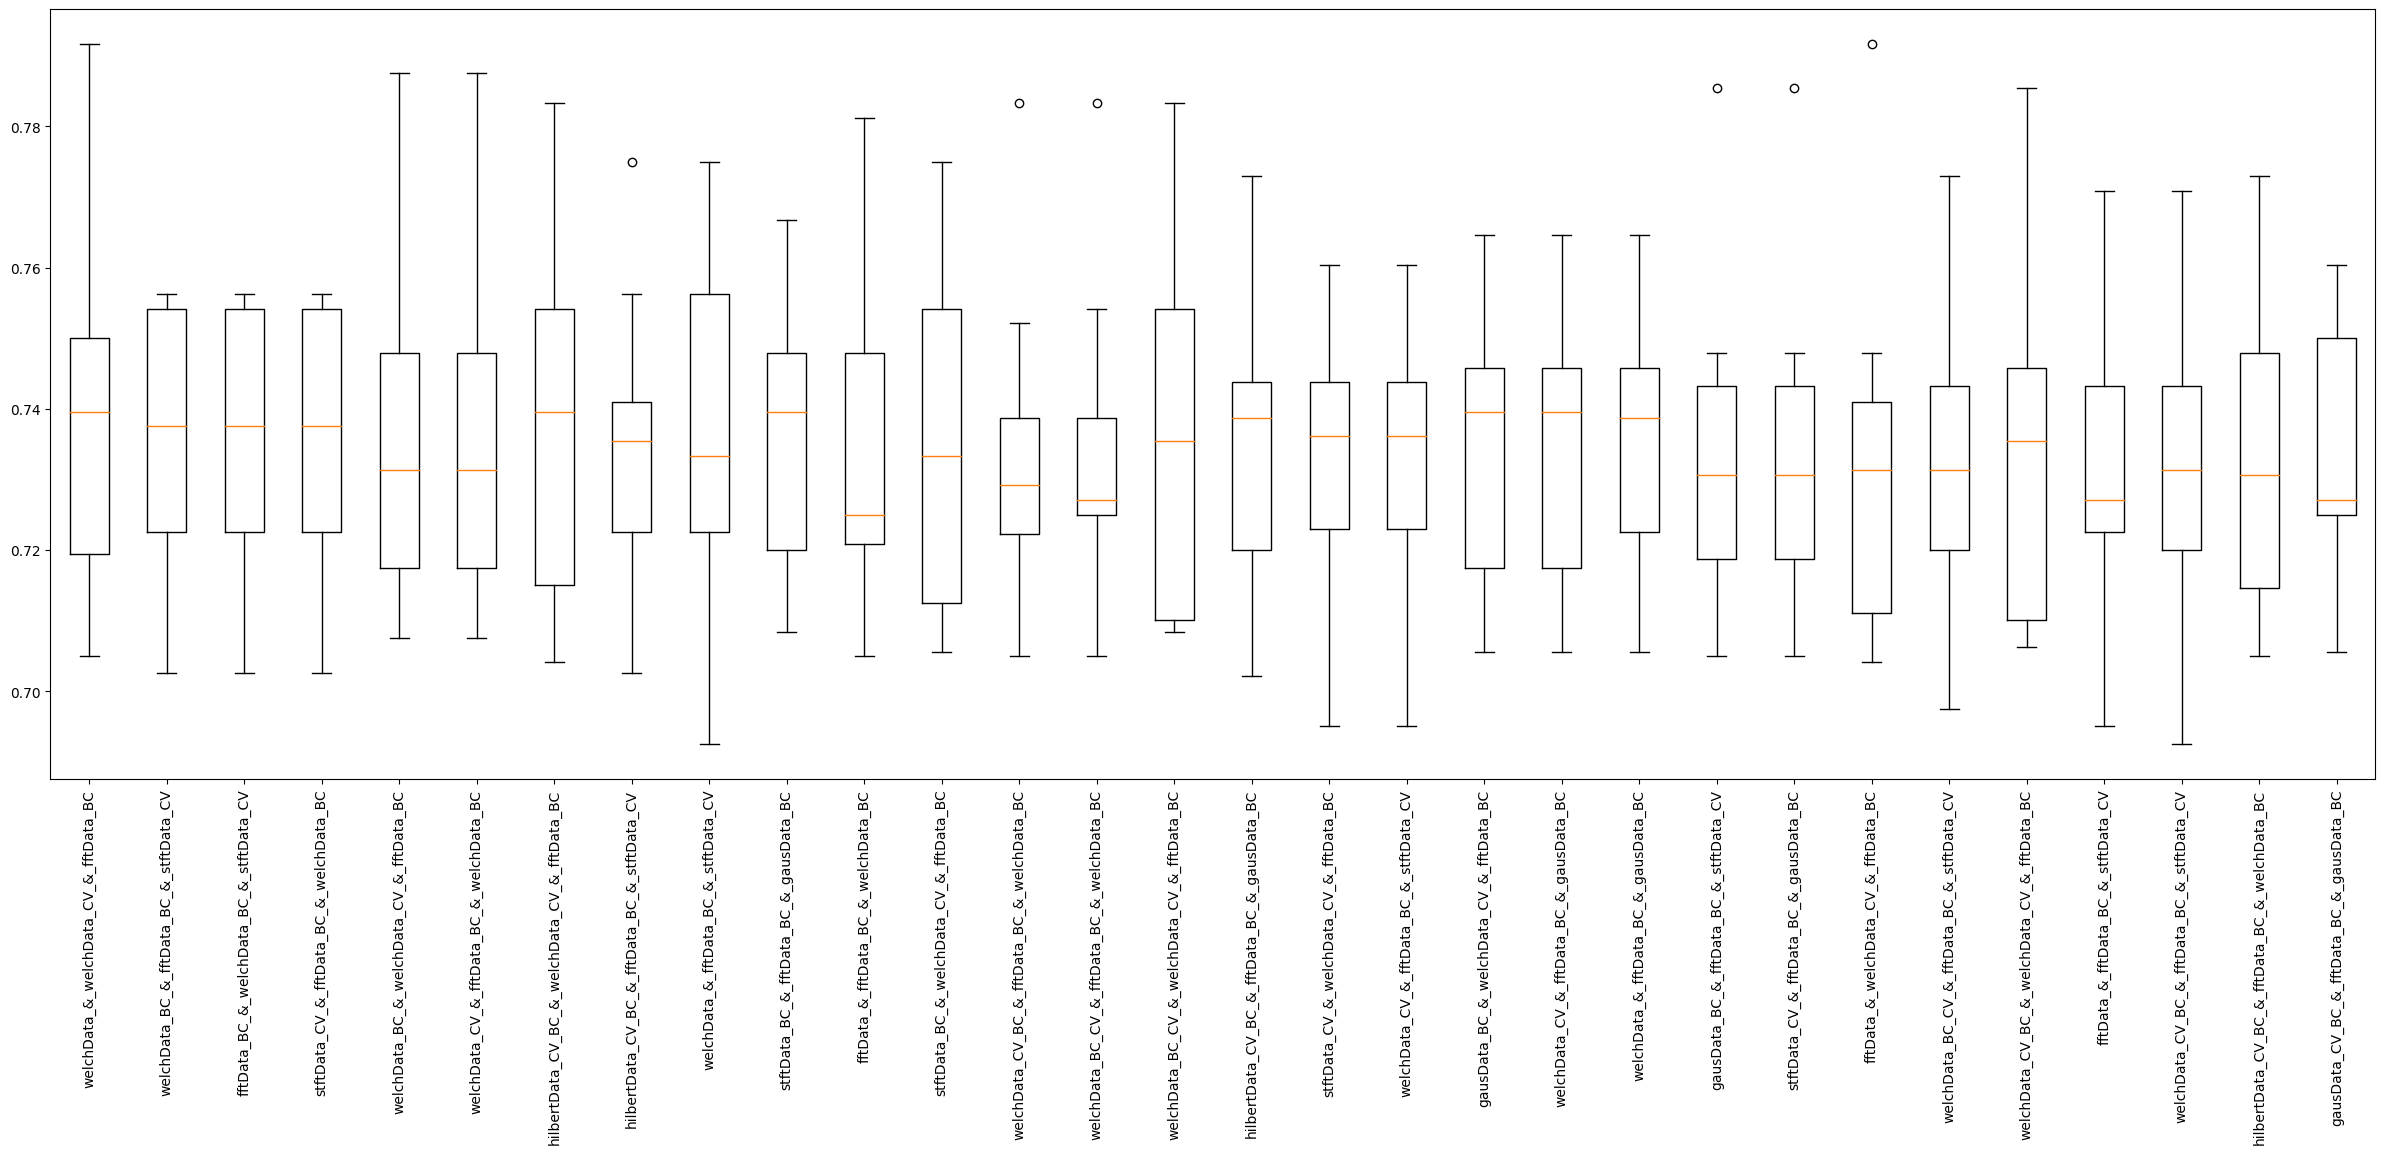

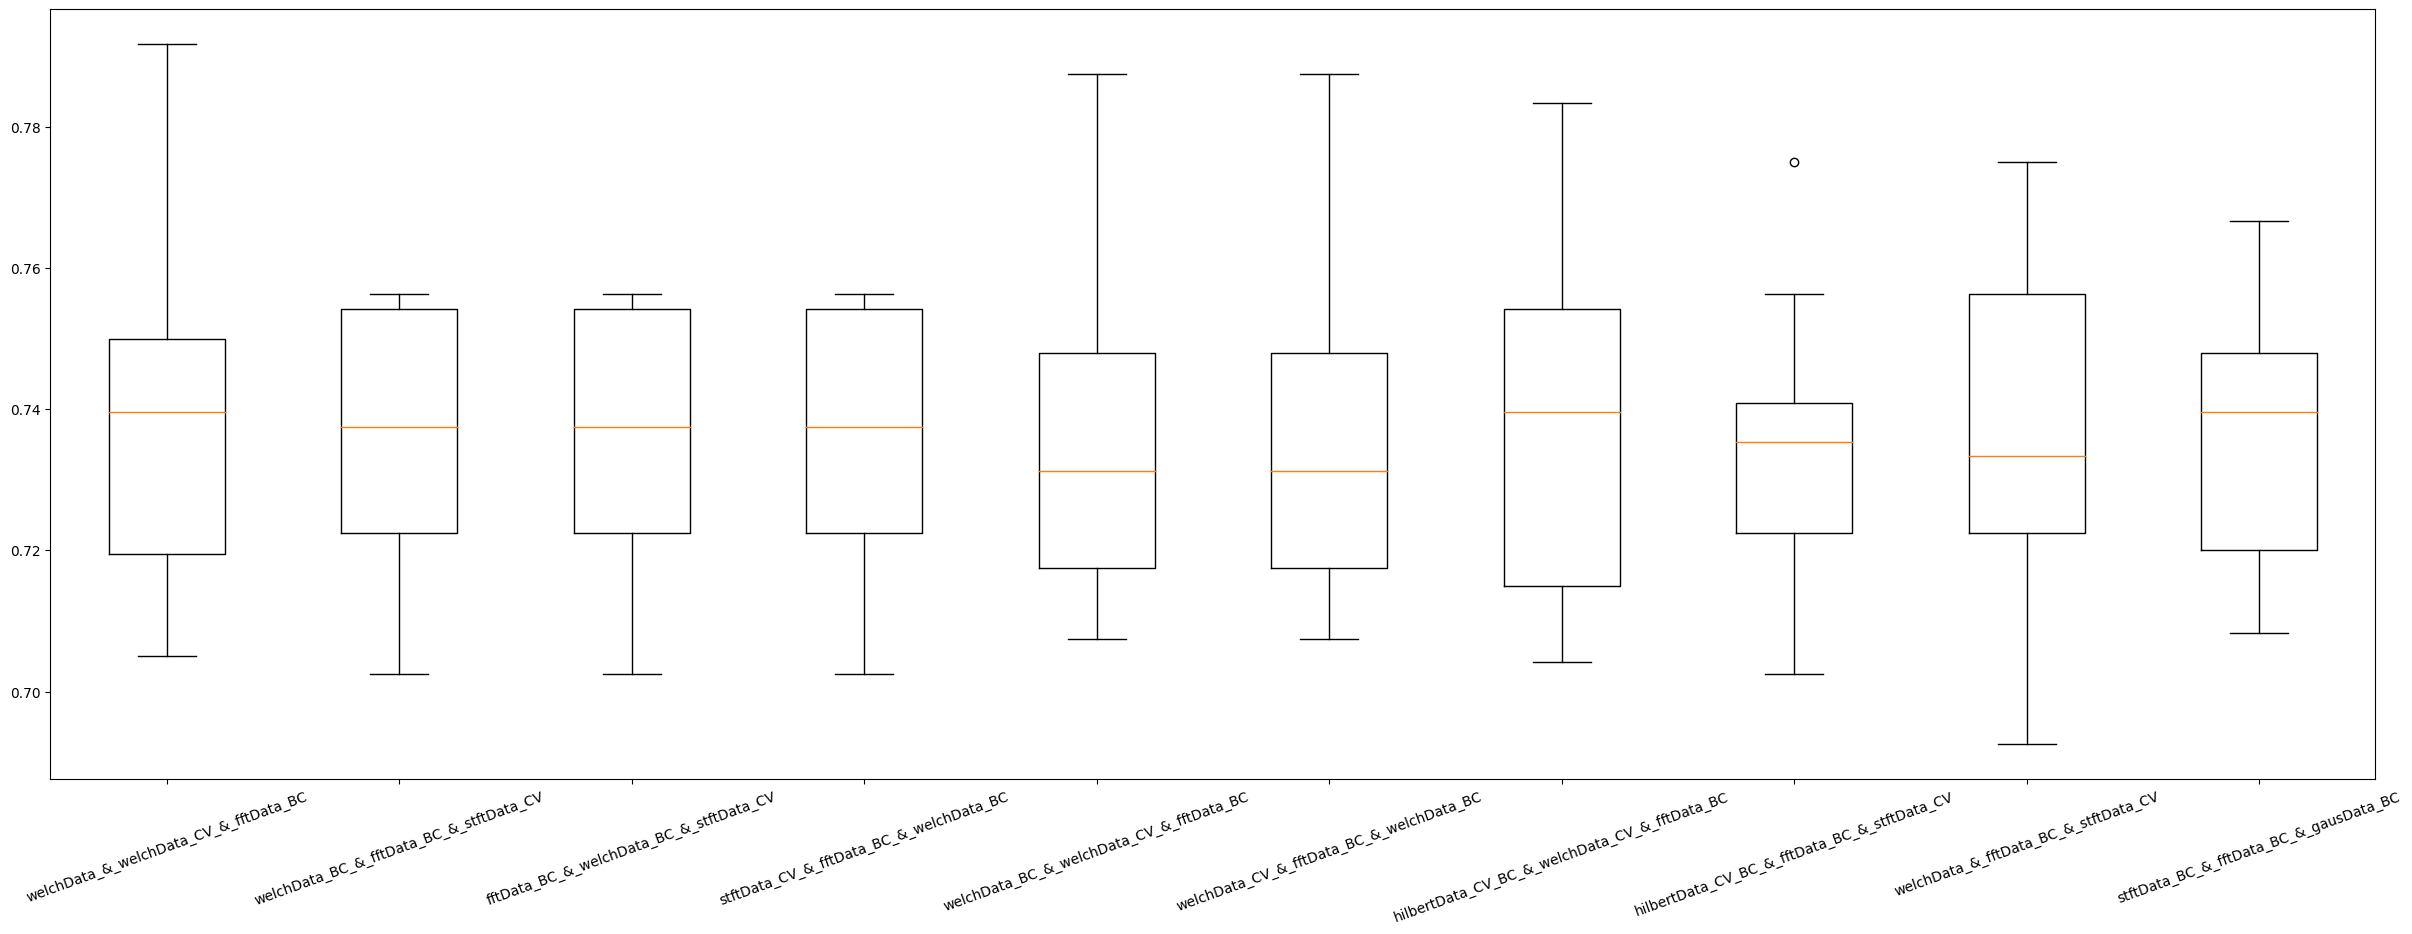

In [610]:
import matplotlib.pyplot as plt
meanTop = np.mean(topPerFeature[1:], axis=0)
indices = np.argsort(meanTop, axis=0)[::-1]

print(indices.shape)
featCombos = np.array(featCombos)

if len(featCombos) < 30:
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(len(featCombos[indices][:30]))+1,featCombos[indices][:30],rotation=45)
    print("")
else: 
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(30)+1,featCombos[indices][:30],rotation=90)
    print("")
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:10])
    plt.xticks(np.arange(10)+1,featCombos[indices][:10],rotation=20)
    print("")
    


In [611]:
print("Top ten highest accuracies")

topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.79 : subject 2, feature:welchData_&_welchData_CV_&_fftData_BC, kernelrbf, C:2.5
Accuracy 0.79 : subject 2, feature:fftData_&_welchData_CV_&_fftData_BC, kernelrbf, C:2.5
Accuracy 0.79 : subject 2, feature:welchData_CV_&_fftData_BC_&_welchData_BC, kernelrbf, C:10
Accuracy 0.79 : subject 2, feature:welchData_CV_&_fftData_BC_&_welchData_BC, kernelrbf, C:5
Accuracy 0.79 : subject 2, feature:welchData_BC_&_welchData_CV_&_fftData_BC, kernelrbf, C:10
Accuracy 0.79 : subject 2, feature:welchData_BC_&_welchData_CV_&_fftData_BC, kernelrbf, C:5
Accuracy 0.79 : subject 5, feature:stftData_CV_&_fftData_BC_&_gausData_BC, kernelsigmoid, C:2.5
Accuracy 0.79 : subject 5, feature:gausData_BC_&_fftData_BC_&_stftData_CV, kernelsigmoid, C:2.5
Accuracy 0.79 : subject 2, feature:welchData_CV_BC_&_welchData_CV_&_fftData_BC, kernelrbf, C:2.5
Accuracy 0.78 : subject 2, feature:welchData_BC_CV_&_welchData_CV_&_fftData_BC, kernelrbf, C:2.5


In [612]:
print("Top ten highest accuracies")
for subTop in topThreeAllSubjects:
    subTop.reverse()

Top ten highest accuracies


In [613]:
topThreeAllSubjects.sort(reverse=True)
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects:
    print("")
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )

arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    skip = False  
    
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)



Accuracy 0.79 : subject 2, feature:welchData_&_welchData_CV_&_fftData_BC, kernelrbf, C:2.5

Accuracy 0.79 : subject 5, feature:stftData_CV_&_fftData_BC_&_gausData_BC, kernelsigmoid, C:2.5

Accuracy 0.77 : subject 8, feature:welchData_&_gausData_CV_&_gausData_BC_CV, kernelsigmoid, C:2.5

Accuracy 0.77 : subject 6, feature:welchData_CV_&_hilbertData_BC_CV_&_gausData_CV_BC, kernellinear, C:0.1

Accuracy 0.76 : subject 3, feature:welchData_CV_BC_&_welchData_BC_&_stftData_CV, kernelsigmoid, C:2.5

Accuracy 0.76 : subject 4, feature:welchData_&_welchData_CV_&_fftData_BC, kernelrbf, C:1.2

Accuracy 0.76 : subject 9, feature:welchData_&_fftData_BC_&_stftData_CV, kernelsigmoid, C:2.5

Accuracy 0.75 : subject 7, feature:welchData_BC_&_fftData_BC_&_stftData_CV, kernelsigmoid, C:2.5

Accuracy 0.74 : subject 1, feature:hilbertData_BC_&_fftData_BC_&_gausData_BC_CV, kernelsigmoid, C:1.2
[array(['welchData', 'welchData_CV', 'fftData_BC'], dtype=object), array(['stftData_CV', 'fftData_BC', 'gausData_B

In [614]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])



[0.         0.66779578 0.66472617 0.65815682 0.69137838 0.67404369
 0.67821621 0.66527226 0.70214256 0.64175202]


,0,6,7,8,9,10,11,12,13,14,15,16,17,18,24,25,26,27,28,29,30,31,32,33,34,35,54,60,61,62,63,64,65,66,67,68,69,70,71,72,78,79,80,81,82,83,84,85,86,87,88,89,90,96,97,98,99,100,101,102,103,104,105,106,107,108,114,115,116,117,118,119,120,121,122,123,124,125,126,132,133,134,135,136,137,138,139,140,141,142,143,144,150,151,152,153,154,155,156,157,158,159,160,161,162,168,169,170,171,172,173,174,175,176,177,178,179,180,186,187,188,189,190,191,192,193,194,195,196,197,216,222,223,224,225,226,227,228,229,230,231,232,233,234,240,241,242,243,244,245,246,247,248,249,250,251,252,258,259,260,261,262,263,264,265,266,267,268,269,270,276,277,278,279,280,281,282,283,284,285,286,287,288,294,295,296,297,298,299,300,301,302,303,304,305,306,312,313,314,315,316,317,318,319,320,321,322,323,324,330,331,332,333,334,335,336,337,338,339,340,341,342,348,349,350,351,352,353,354,355,356,357,358,359,378,384,385,386,387,388,389,390,391,392,393,394,395,396,402,403,404,405,406,407,408,409,410,411,412,413,414,420,421,422,423,424,425,426,427,428,429,430,431,432,438,439,440,441,442,443,444,445,446,447,448,449,450,456,457,458,459,460,461,462,463,464,465,466,467,468,474,475,476,477,478,479,480,481,482,483,484,485,486,492,493,494,495,496,497,498,499,500,501,502,503,504,510,511,512,513,514,515,516,517,518,519,520,521,540,546,547,548,549,550,551,552,553,554,555,556,557,558,564,565,566,567,568,569,570,571,572,573,574,575,576,582,583,584,585,586,587,588,589,590,591,592,593,594,600,601,602,603,604,605,606,607,608,609,610,611,612,618,619,620,621,622,623,624,625,626,627,628,629,630,636,637,638,639,640,641,642,643,644,645,646,647,648,654,655,656,657,658,659,660,661,662,663,664,665,684,690,691,692,693,694,695,696,697,698,699,700,701,702,708,709,710,711,712,713,714,715,716,717,718,719,720,726,727,728,729,730,731,732,733,734,735,736,737,738,744,745,746,747,748,749,750,751,752,753,754,755,756,762,763,764,765,766,767,768,769,770,771,772,773,774,780,781,782,783,784,785,786,787,788,789,790,791,792,798,799,800,801,802,803,804,805,806,807,808,809,810,816,817,818,819,820,821,822,823,824,825,826,827,846,852,853,854,855,856,857,858,859,860,861,862,863,864,870,871,872,873,874,875,876,877,878,879,880,881,882,888,889,890,891,892,893,894,895,896,897,898,899,900,906,907,908,909,910,911,912,913,914,915,916,917,918,924,925,926,927,928,929,930,931,932,933,934,935,936,942,943,944,945,946,947,948,949,950,951,952,953,954,960,961,962,963,964,965,966,967,968,969,970,971,972,978,979,980,981,982,983,984,985,986,987,988,989,1008,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1224,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1320,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1350,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1366,1367,1368,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440,1446,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1464,1465,146

Max average accuracy 0.7261980920314253


In [615]:
print("Based on combAverage")
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
for maxInd,res in zip(top5, top5Vals):
    #print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combAverage
stftData_CV_&_fftData_BC_&_welchData_BC
sigmoid
0.7261980920314253

welchData_BC_&_fftData_BC_&_stftData_CV
sigmoid
0.7261980920314253

fftData_BC_&_welchData_BC_&_stftData_CV
sigmoid
0.7261980920314253

stftData_CV_&_fftData_BC_&_gausData_BC
sigmoid
0.7252384960718294

gausData_BC_&_fftData_BC_&_stftData_CV
sigmoid
0.7252384960718294



In [616]:
print("Based on combTotal")
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combTotal
stftData_CV_&_fftData_BC_&_welchData_BC
sigmoid
0.7261980920314253

welchData_BC_&_fftData_BC_&_stftData_CV
sigmoid
0.7261980920314253

fftData_BC_&_welchData_BC_&_stftData_CV
sigmoid
0.7261980920314253

stftData_CV_&_fftData_BC_&_gausData_BC
sigmoid
0.7252384960718294

gausData_BC_&_fftData_BC_&_stftData_CV
sigmoid
0.7252384960718294



In [617]:
table = pd.DataFrame(np.array(comboTotal), columns=headers)
display(table)

maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

for maxInd2 in np.where(comboTotal == maxVal2)[1]:
    print(headers[maxInd2])
    print(nrOfSubjects[maxInd2])
    print(
        f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
    )
    print(allCombinations[maxInd2][0])
    print(allCombinations[maxInd2][1])
    print(f"C: {allCombinations[maxInd2][2]} ")


,0,6,7,8,9,10,11,12,13,14,15,16,17,18,24,25,26,27,28,29,30,31,32,33,34,35,54,60,61,62,63,64,65,66,67,68,69,70,71,72,78,79,80,81,82,83,84,85,86,87,88,89,90,96,97,98,99,100,101,102,103,104,105,106,107,108,114,115,116,117,118,119,120,121,122,123,124,125,126,132,133,134,135,136,137,138,139,140,141,142,143,144,150,151,152,153,154,155,156,157,158,159,160,161,162,168,169,170,171,172,173,174,175,176,177,178,179,180,186,187,188,189,190,191,192,193,194,195,196,197,216,222,223,224,225,226,227,228,229,230,231,232,233,234,240,241,242,243,244,245,246,247,248,249,250,251,252,258,259,260,261,262,263,264,265,266,267,268,269,270,276,277,278,279,280,281,282,283,284,285,286,287,288,294,295,296,297,298,299,300,301,302,303,304,305,306,312,313,314,315,316,317,318,319,320,321,322,323,324,330,331,332,333,334,335,336,337,338,339,340,341,342,348,349,350,351,352,353,354,355,356,357,358,359,378,384,385,386,387,388,389,390,391,392,393,394,395,396,402,403,404,405,406,407,408,409,410,411,412,413,414,420,421,422,423,424,425,426,427,428,429,430,431,432,438,439,440,441,442,443,444,445,446,447,448,449,450,456,457,458,459,460,461,462,463,464,465,466,467,468,474,475,476,477,478,479,480,481,482,483,484,485,486,492,493,494,495,496,497,498,499,500,501,502,503,504,510,511,512,513,514,515,516,517,518,519,520,521,540,546,547,548,549,550,551,552,553,554,555,556,557,558,564,565,566,567,568,569,570,571,572,573,574,575,576,582,583,584,585,586,587,588,589,590,591,592,593,594,600,601,602,603,604,605,606,607,608,609,610,611,612,618,619,620,621,622,623,624,625,626,627,628,629,630,636,637,638,639,640,641,642,643,644,645,646,647,648,654,655,656,657,658,659,660,661,662,663,664,665,684,690,691,692,693,694,695,696,697,698,699,700,701,702,708,709,710,711,712,713,714,715,716,717,718,719,720,726,727,728,729,730,731,732,733,734,735,736,737,738,744,745,746,747,748,749,750,751,752,753,754,755,756,762,763,764,765,766,767,768,769,770,771,772,773,774,780,781,782,783,784,785,786,787,788,789,790,791,792,798,799,800,801,802,803,804,805,806,807,808,809,810,816,817,818,819,820,821,822,823,824,825,826,827,846,852,853,854,855,856,857,858,859,860,861,862,863,864,870,871,872,873,874,875,876,877,878,879,880,881,882,888,889,890,891,892,893,894,895,896,897,898,899,900,906,907,908,909,910,911,912,913,914,915,916,917,918,924,925,926,927,928,929,930,931,932,933,934,935,936,942,943,944,945,946,947,948,949,950,951,952,953,954,960,961,962,963,964,965,966,967,968,969,970,971,972,978,979,980,981,982,983,984,985,986,987,988,989,1008,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1224,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1320,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1350,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1366,1367,1368,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440,1446,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1464,1465,146

1167
9.0
Max total significant accuracy then averaged 0.7261980920314253 
welchData_CV_&_fftData_BC_&_gausData_BC
sigmoid
C: 0.5 
1257
9.0
Max total significant accuracy then averaged 0.7261980920314253 
hilbertData_CV_&_welchData_CV_&_fftData_BC
rbf
C: 10 
2895
9.0
Max total significant accuracy then averaged 0.7261980920314253 
hilbertData_BC_CV_&_fftData_BC_&_stftData_CV
linear
C: 1.2 


In [618]:
for names in featCombos:
    print(names)



fftData_&_welchData_CV_&_fftData_BC
fftData_&_gausData_CV_&_gausData_BC_CV
fftData_&_fftData_BC_&_stftData_CV
fftData_&_hilbertData_BC_CV_&_gausData_CV_BC
fftData_&_welchData_BC_&_stftData_CV
fftData_&_fftData_BC_&_stftData_CV
fftData_&_fftData_BC_&_gausData_BC
fftData_&_fftData_BC_&_welchData_BC
fftData_&_fftData_BC_&_gausData_BC_CV
welchData_&_welchData_CV_&_fftData_BC
welchData_&_gausData_CV_&_gausData_BC_CV
welchData_&_fftData_BC_&_stftData_CV
welchData_&_hilbertData_BC_CV_&_gausData_CV_BC
welchData_&_welchData_BC_&_stftData_CV
welchData_&_fftData_BC_&_stftData_CV
welchData_&_fftData_BC_&_gausData_BC
welchData_&_fftData_BC_&_welchData_BC
welchData_&_fftData_BC_&_gausData_BC_CV
hilbertData_&_welchData_CV_&_fftData_BC
hilbertData_&_gausData_CV_&_gausData_BC_CV
hilbertData_&_fftData_BC_&_stftData_CV
hilbertData_&_hilbertData_BC_CV_&_gausData_CV_BC
hilbertData_&_welchData_BC_&_stftData_CV
hilbertData_&_fftData_BC_&_stftData_CV
hilbertData_&_fftData_BC_&_gausData_BC
hilbertData_&_fftDat